In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:

import os
import shutil

# Define the source folder
source_folder = "/content/drive/MyDrive/chick_or_duck"

# Define the destination folders
train_folder = "/content/drive/MyDrive/chick_or_duck/train"
test_folder = "/content/drive/MyDrive/chick_or_duck/test"
val_folder = "/content/drive/MyDrive/chick_or_duck/val"

## 🐣 Dataset Organizer: Chick vs Duck

In [3]:
import os
import shutil
from pathlib import Path

# Base path containing the categorized images
base_dir = Path("/content/drive/MyDrive/chick_or_duck")

# Folders to hold the split data
splits = {
    "train": base_dir / "train",
    "test": base_dir / "test",
    "val": base_dir / "val"
}

# Ensure target directories exist
for folder in splits.values():
    folder.mkdir(parents=True, exist_ok=True)

# Category labels
labels = ["duck", "chick"]

# Percentage split
ratios = {"train": 0.7, "test": 0.15}

# Process each category
for label in labels:
    label_path = base_dir / label
    image_files = sorted(label_path.iterdir())

    total = len(image_files)
    n_train = int(total * ratios["train"])
    n_test = int(total * ratios["test"])
    n_val = total - n_train - n_test

    # Slice the list of images
    split_data = {
        "train": image_files[:n_train],
        "test": image_files[n_train:n_train+n_test],
        "val": image_files[n_train+n_test:]
    }

    # Copy files to respective folders
    for split_name, file_list in split_data.items():
        target_dir = splits[split_name] / label
        target_dir.mkdir(parents=True, exist_ok=True)
        for img_file in file_list:
            shutil.copy(img_file, target_dir)


## 🖼️ Image Loading & Preprocessing with OpenCV

In [4]:
import cv2
from pathlib import Path

# Helper function to load and preprocess images from a given directory
def load_images_from_directory(directory):
    data = []
    directory = Path(directory)

    for class_dir in directory.iterdir():
        if class_dir.is_dir():
            for image_file in class_dir.iterdir():
                img = cv2.imread(str(image_file))
                if img is not None:
                    resized_img = cv2.resize(img, (224, 224))
                    data.append(resized_img)
    return data

# Load the datasets
train_images = load_images_from_directory(splits["train"])
test_images = load_images_from_directory(splits["test"])
val_images = load_images_from_directory(splits["val"])


## ⚙️ Normalization & Data Generator Setup

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert lists to NumPy arrays and normalize manually
train_arr = np.asarray(train_images) / 255.0
test_arr = np.asarray(test_images) / 255.0
val_arr = np.asarray(val_images) / 255.0

# Create a generic data generator with normalization
gen_config = dict(rescale=1.0 / 255)
data_gen = ImageDataGenerator(**gen_config)

# Parameters for image loading
img_size = (224, 224)
batch_sz = 32
mode = 'sparse'

# Load images using flow_from_directory
train_batches = data_gen.flow_from_directory(
    directory=splits["train"],
    target_size=img_size,
    batch_size=batch_sz,
    class_mode=mode,
    shuffle=True
)

test_batches = data_gen.flow_from_directory(
    directory=splits["test"],
    target_size=img_size,
    batch_size=batch_sz,
    class_mode=mode,
    shuffle=True
)

val_batches = data_gen.flow_from_directory(
    directory=splits["val"],
    target_size=img_size,
    batch_size=batch_sz,
    class_mode=mode,
    shuffle=True
)


Found 188 images belonging to 2 classes.
Found 74 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


## 🏷️ Extracting Class Labels from Data Generators

In [6]:
# Fetch labels from the directory-based generators
y_train_labels = train_batches.classes
y_test_labels = test_batches.classes
y_val_labels = val_batches.classes


## 🧠 Load & Freeze Pretrained VGG19 Base (Modified Version)

In [7]:
from tensorflow.keras.applications import VGG19

# Load VGG19 without top layers, using pretrained ImageNet weights
vgg_model = VGG19(
    input_shape=(224, 224, 3),
    weights="imagenet",
    include_top=False
)

# Freeze all layers to prevent training
for block in vgg_model.layers:
    block.trainable = False


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 🧱 Custom Classification Head on VGG19

In [8]:

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Build the classification head on top of the VGG19 base
flattened_output = Flatten()(vgg_model.output)

# Adding a series of Dense layers with Dropout
fc1 = Dense(24, activation='relu')(flattened_output)
fc2 = Dense(36, activation='relu')(fc1)
drop1 = Dropout(0.25)(fc2)
fc3 = Dense(24, activation='relu')(drop1)
drop2 = Dropout(0.25)(fc3)
fc4 = Dense(12, activation='relu')(drop2)
fc5 = Dense(6, activation='relu')(fc4)

# Final output layer using sigmoid (binary classification)
final_output = Dense(1, activation='sigmoid')(fc5)

# Create the final model
cnn_model = Model(inputs=vgg_model.input, outputs=final_output)


# view the structure of the model
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │       602,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │           90

 Total params: 20,628,693 (78.69 MB)

 Trainable params: 604,309 (2.31 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

## 🛠️ Compiling the CNN Model

In [9]:
from tensorflow.keras.optimizers import Adam

# Define compile configuration
compile_config = {
    "loss": "binary_crossentropy",
    "optimizer": Adam(),
    "metrics": ["accuracy"]
}

# Compile the model
cnn_model.compile(**compile_config)


## ⏹️ Setting Up Callbacks for Training

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Initialize early stopping to monitor validation loss
stop_early = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1
)

# Callback to store model with lowest validation loss
checkpoint_loss = ModelCheckpoint(
    'best_val_loss_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Callback to store model with highest validation accuracy
checkpoint_acc = ModelCheckpoint(
    'best_val_acc_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


## 🚀 Training the Model Using Data Generators

In [ ]:
# Train the CNN model using early stopping and checkpoints
training_history = cnn_model.fit(
    x=train_arr,
    y= y_train_labels,
    validation_data=(val_arr, y_val_labels),
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[stop_early, checkpoint_loss, checkpoint_acc]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.5001 - loss: 0.7072 - val_accuracy: 0.6792 - val_loss: 0.6295
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.5790 - loss: 0.6553 - val_accuracy: 0.8113 - val_loss: 0.5867
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.8284 - loss: 0.5603 - val_accuracy: 0.9245 - val_loss: 0.4559
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.7542 - loss: 0.4946 - val_accuracy: 0.9245 - val_loss: 0.3379
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.8296 - loss: 0.4036 - val_accuracy: 0.9245 - val_loss: 0.2194
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.9142 - loss: 0.2459 - val_accuracy: 0.9434 - val_loss: 0.1716
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.9087 - loss: 0.1950 - val_accuracy: 0.9623 - val_loss: 0.1273
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.9576 - loss: 0.1676 - val_accuracy: 0.9623 - val_loss: 0

## 📊 Visualizing Accuracy and Loss Curves

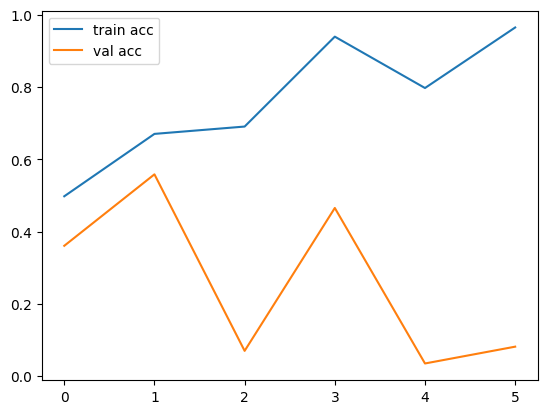

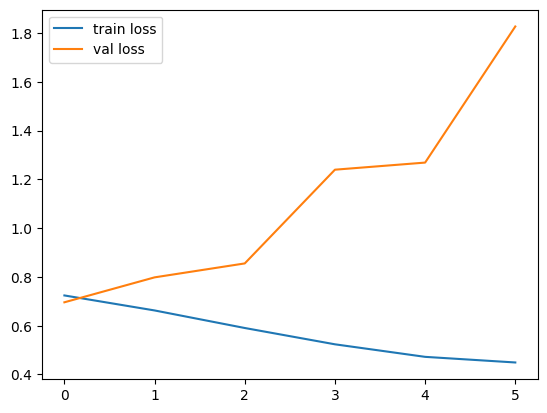

In [ ]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()


In [ ]:
model.evaluate(test_x,test_y,batch_size=32)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.1388 - loss: 1.5361


[1.9651744365692139, 0.09782608598470688]

In [ ]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification


x = Dense(12, activation="relu")(x)
x = Dense(24, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(36, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(24, activation="relu")(x)
x = Dense(12, activation="relu")(x)
prediction = Dense(1, activation='sigmoid')(x)

model_loss = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model_loss.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
model_loss.load_weights('/content/least_loss.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model_loss.evaluate(test_x,test_y,batch_size=32)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.3079 - loss: 0.6958


[0.6938671469688416, 0.46739131212234497]

In [ ]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification


x = Dense(12, activation="relu")(x)
x = Dense(24, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(36, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(24, activation="relu")(x)
x = Dense(12, activation="relu")(x)
prediction = Dense(1, activation='sigmoid')(x)

model_acc = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model_acc.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
model_acc.load_weights('/content/max_acc.keras')

In [ ]:
model_acc.evaluate(test_x,test_y,batch_size=32)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.6703 - loss: 0.7322


[0.8235835433006287, 0.489130437374115]